In [1]:
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import pandas as pd
import seaborn as sns
import pymc3 as pm
import arviz as az

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
az.style.use('arviz-darkgrid')

## Bayesian Statistic with Pymc3

In [3]:
np.random.seed(123)
trials = 4
theta_real = 0.35  # unknown value in a real experiment
data = stats.bernoulli.rvs(p=theta_real, size=trials)
data

array([1, 0, 0, 0])

In [4]:
with pm.Model() as our_first_model:
    θ = pm.Beta('θ', alpha=1., beta=1.) # Prior
    y = pm.Bernoulli('y', p=θ, observed=data) # LIkelihood
    idata = pm.sample(1000, random_seed=123, return_inferencedata=True) # 1000번 theta를 샘플링

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 39 seconds.


array([[<AxesSubplot:title={'center':'θ'}>,
        <AxesSubplot:title={'center':'θ'}>]], dtype=object)

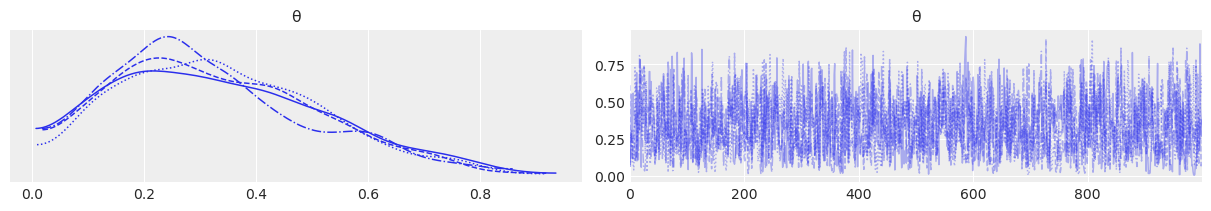

In [5]:
az.plot_trace(idata)

왼쪽 그래프는 Kernel Density Estimation 그래프이고, 오른쪽은 각각의 샘플에 대한 그래프이다.

In [6]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
θ,0.332,0.18,0.016,0.65,0.005,0.003,1418.0,1928.0,1.0


<AxesSubplot:title={'center':'θ'}>

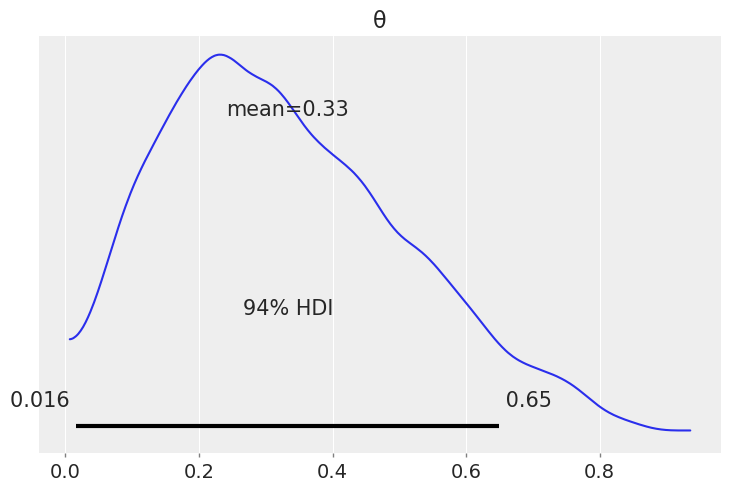

In [7]:
az.plot_posterior(idata)

arviz 라이브러리를 통해 바로 Posterior를 볼 수 있다.

## Posterior 기반으로 의사결정

<AxesSubplot:title={'center':'θ'}>

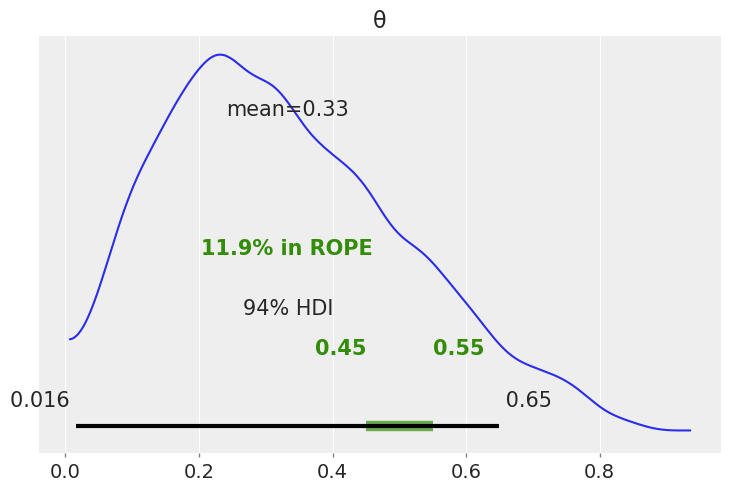

In [8]:
az.plot_posterior(idata, rope=[0.45, 0.55])

ROPE가 HDI를 부분적으로 포함하고 있으므로 동전이 Fair 거나 Unfair다.

<AxesSubplot:title={'center':'θ'}>

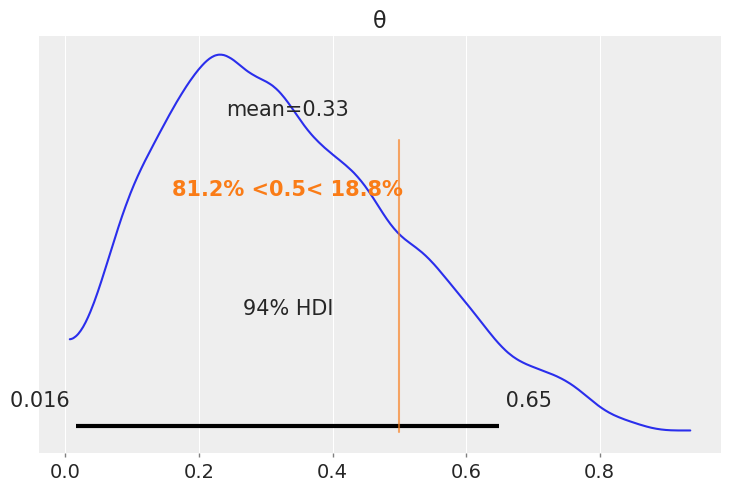

In [9]:
az.plot_posterior(idata, ref_val=0.5)

## Loss Function

In [10]:
grid = np.linspace(0, 1, 200)
θ_pos = idata.posterior['θ']

In [11]:
lossf_a = [np.mean(abs(i - θ_pos)) for i in grid] # Absolute Loss function
lossf_b = [np.mean((i - θ_pos)**2) for i in grid] # Quadric Loss function

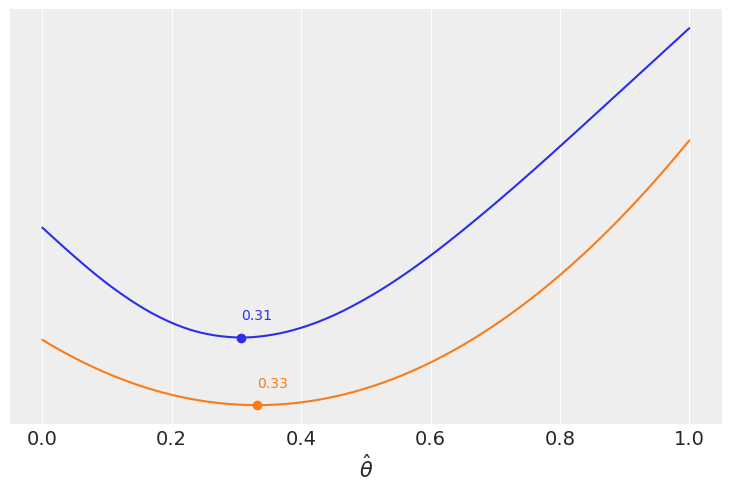

In [12]:
for lossf, c in zip([lossf_a, lossf_b], ['C0', 'C1']):
    mini = np.argmin(lossf)
    plt.plot(grid, lossf, c)
    plt.plot(grid[mini], lossf[mini], 'o', color=c)
    plt.annotate('{:.2f}'.format(grid[mini]),
                 (grid[mini], lossf[mini] + 0.03), color=c)
    plt.yticks([])
    plt.xlabel(r'$\hat \theta$')

신기한 것은 Absolute Loss function에 의해 선택된 $\theta$값은 Posterior의 Median 값이고, Quadric Loss function에 의해 선택된 $\theta$의 값은 Posterior의 Mean 값이다.

In [13]:
np.mean(θ_pos).item(), np.median(θ_pos)

(0.33183370277313406, 0.30799294354216683)

Text(0.5, 0, '$\\hat \\theta$')

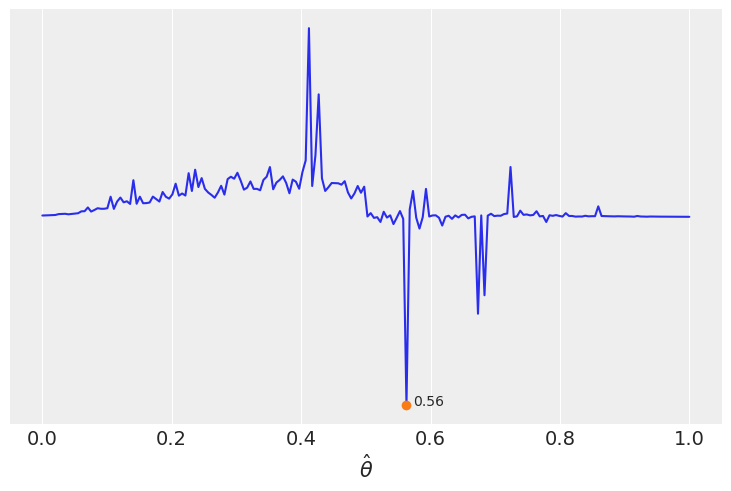

In [14]:
lossf = []
for i in grid:
    if i < 0.5:
        f = np.mean(np.pi * θ_pos / np.abs(i - θ_pos))
    else:
        f = np.mean(1 / (i - θ_pos))
    lossf.append(f)

mini = np.argmin(lossf)
plt.plot(grid, lossf)
plt.plot(grid[mini], lossf[mini], 'o')
plt.annotate('{:.2f}'.format(grid[mini]),
             (grid[mini] + 0.01, lossf[mini] + 0.1))
plt.yticks([])
plt.xlabel(r'$\hat \theta$')

## Gaussian inferences

In [15]:
data = np.loadtxt('./data/chemical_shifts.csv')
data

array([51.06, 55.12, 53.73, 50.24, 52.05, 56.4 , 48.45, 52.34, 55.65,
       51.49, 51.86, 63.43, 53.  , 56.09, 51.93, 52.31, 52.33, 57.48,
       57.44, 55.14, 53.93, 54.62, 56.09, 68.58, 51.36, 55.47, 50.73,
       51.94, 54.95, 50.39, 52.91, 51.5 , 52.68, 47.72, 49.73, 51.82,
       54.99, 52.84, 53.19, 54.52, 51.46, 53.73, 51.61, 49.81, 52.42,
       54.3 , 53.84, 53.16])

interquartile rule을 이용하여 outlier 제거

In [16]:
quant = np.percentile(data, [25, 75])
iqr = quant[1] - quant[0]
upper_b = quant[1] + iqr * 1.5
lower_b = quant[0] - iqr * 1.5
data = data[(data > lower_b) & (data < upper_b)]
print(np.mean(data), np.std(data))

52.95260869565218 2.1950303897892387


([<matplotlib.axis.YTick at 0x23bb04b1120>], [Text(0, 0, '')])

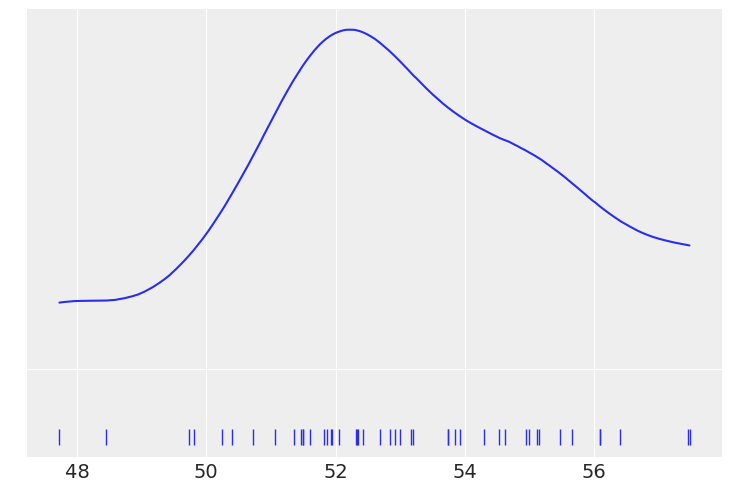

In [17]:
az.plot_kde(data, rug=True)
plt.yticks([0], alpha=0)

In [18]:
with pm.Model() as model_g:
    μ = pm.Uniform('μ', lower=40, upper=70) # mu의 분포를 40~70
    σ = pm.HalfNormal('σ', sd=10) # sigma의 분포를 Half 정규분포로 가정
    y = pm.Normal('y', mu=μ, sd=σ, observed=data)
    idata_g = pm.sample(1000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 50 seconds.


array([[<AxesSubplot:title={'center':'μ'}>,
        <AxesSubplot:title={'center':'μ'}>],
       [<AxesSubplot:title={'center':'σ'}>,
        <AxesSubplot:title={'center':'σ'}>]], dtype=object)

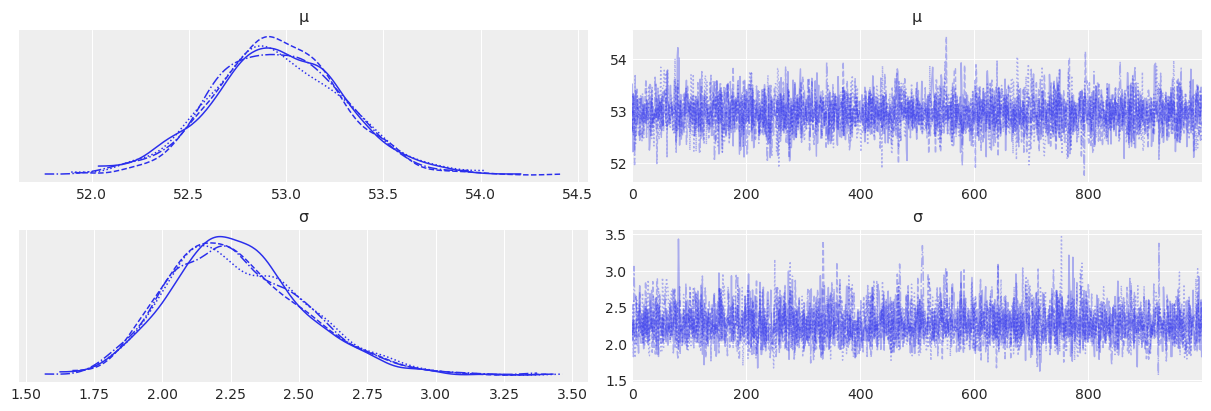

In [19]:
az.plot_trace(idata_g)

Posterior가 $\mu$와 $\sigma$의 분포이므로 이차원 분포형태다. 즉 trace를 통해 보여주는 것도 marginal distribution이다.  
예를들어 분포가 (x, y)의 2차원 분포를 따를때 y를 전부 적분했을때 x의 분포를 marginal distribution이라고 한다.

C:\Anaconda3\envs\pymc_env\lib\site-packages\arviz\plots\jointplot.py:145: UserWarning: plot_joint will be deprecated. Please use plot_pair instead.
  warnings.warn("plot_joint will be deprecated. Please use plot_pair instead.")


array([<AxesSubplot:xlabel='μ', ylabel='σ'>, <AxesSubplot:>,
       <AxesSubplot:>], dtype=object)

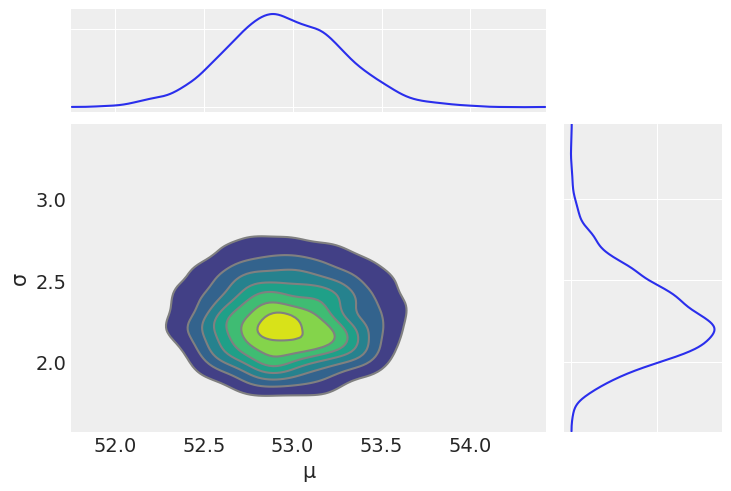

In [20]:
az.plot_joint(idata_g, kind='kde', fill_last=False)

In [21]:
az.summary(idata_g)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
μ,52.955,0.337,52.348,53.606,0.006,0.004,3564.0,2350.0,1.0
σ,2.275,0.249,1.834,2.746,0.004,0.003,3175.0,2547.0,1.0


In [22]:
y_pred_g = pm.sample_posterior_predictive(idata_g, model=model_g, keep_size=True)

Posterior를 통해 값을 생성

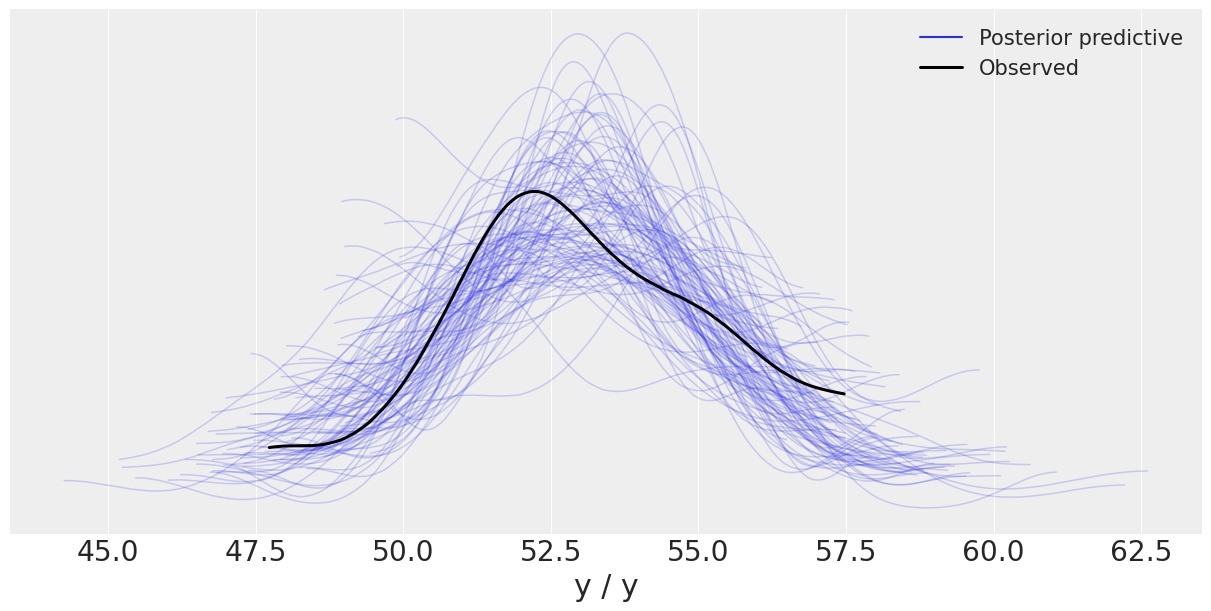

In [23]:
az.concat(idata_g, az.from_dict(posterior_predictive=y_pred_g), inplace=True)
ax = az.plot_ppc(idata_g, num_pp_samples=100, figsize=(12, 6), mean=False)

## Robust inferences

(-5.0, 5.0)

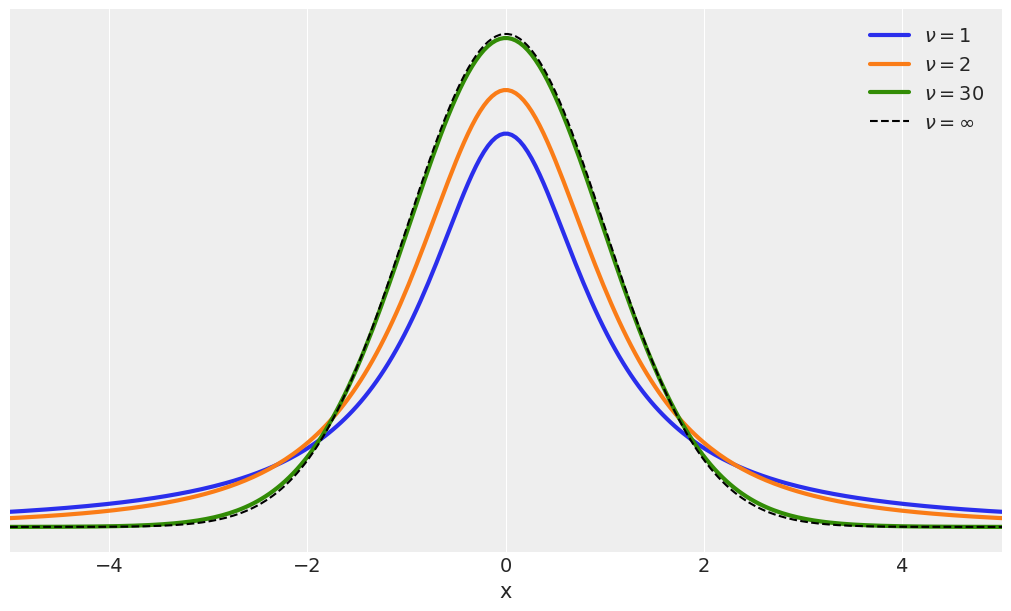

In [24]:
plt.figure(figsize=(10, 6))
x_values = np.linspace(-10, 10, 500)
for df in [1, 2, 30]:
    distri = stats.t(df)
    x_pdf = distri.pdf(x_values)
    plt.plot(x_values, x_pdf, label=fr'$\nu = {df}$', lw=3)

x_pdf = stats.norm.pdf(x_values)
plt.plot(x_values, x_pdf, 'k--', label=r'$\nu = \infty$')
plt.xlabel('x')
plt.yticks([])
plt.legend()
plt.xlim(-5, 5)

$\nu$의 값이 커질 수록 정규분포와 비슷해지고, 작을 수록 tail 부분도 많이 고려를 하게 된다.

In [25]:
with pm.Model() as model_t:
    μ = pm.Uniform('μ', 40, 75) # 평균의 분포
    σ = pm.HalfNormal('σ', sd=10) # Scale의 분포
    ν = pm.Exponential('ν', 1/30) # 자유도의 분포
    y = pm.StudentT('y', mu=μ, sd=σ, nu=ν, observed=data)
    idata_t = pm.sample(1000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ν, σ, μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 40 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


array([[<AxesSubplot:title={'center':'μ'}>,
        <AxesSubplot:title={'center':'μ'}>],
       [<AxesSubplot:title={'center':'σ'}>,
        <AxesSubplot:title={'center':'σ'}>],
       [<AxesSubplot:title={'center':'ν'}>,
        <AxesSubplot:title={'center':'ν'}>]], dtype=object)

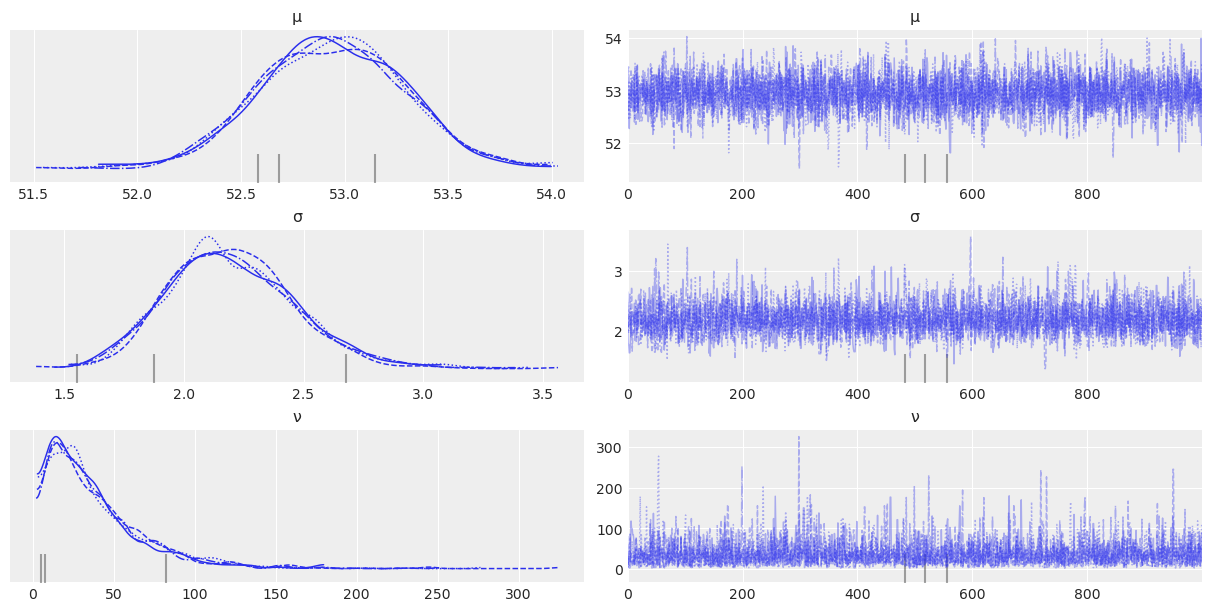

In [26]:
az.plot_trace(idata_t)

In [27]:
az.summary(idata_t)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
μ,52.939,0.345,52.286,53.555,0.005,0.004,4339.0,3089.0,1.0
σ,2.199,0.265,1.722,2.696,0.005,0.003,3405.0,2334.0,1.0
ν,38.391,31.250,2.793,92.806,0.537,0.416,3549.0,2574.0,1.0


(40.0, 70.0)

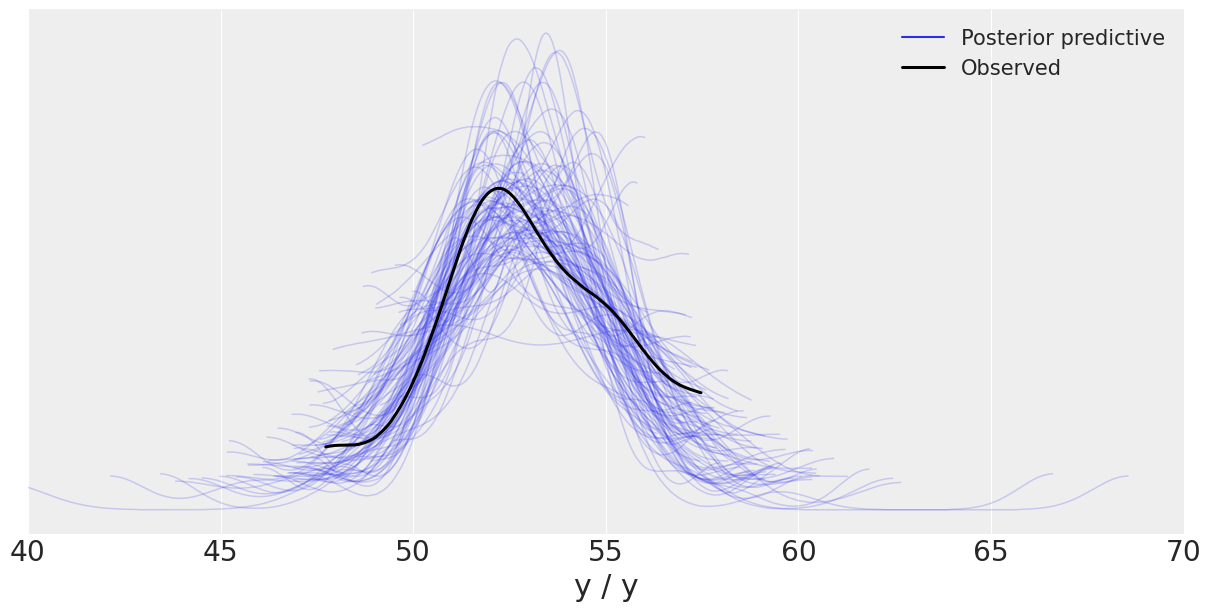

In [28]:
y_ppc_t = pm.sample_posterior_predictive(
    idata_t, model=model_t, random_seed=123, keep_size=True)
az.concat(idata_t, az.from_dict(posterior_predictive=y_ppc_t), inplace=True)
az.plot_ppc(idata_t, figsize=(12, 6), mean=False, num_pp_samples=100)
plt.xlim(40, 70)

## Group 비교 - Tips example

In [29]:
tips = pd.read_csv('./data/tips.csv')
tips.tail()

,total_bill,tip,sex,smoker,day,time,size
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2
243,18.78,3.00,Female,No,Thur,Dinner,2


<AxesSubplot:xlabel='day', ylabel='tip'>

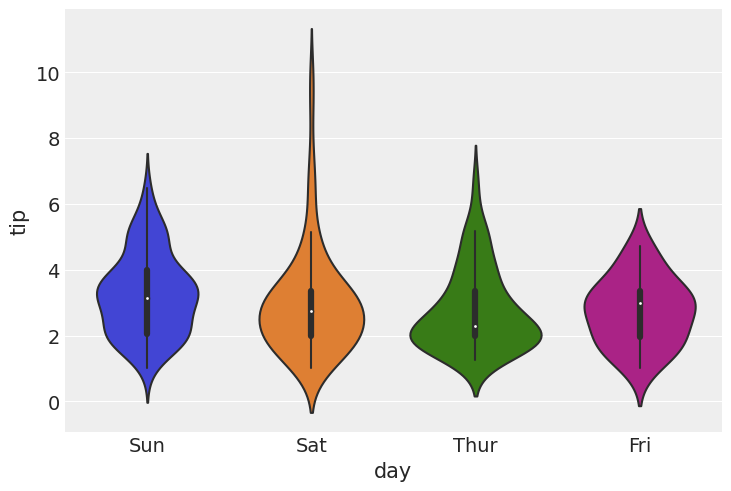

In [30]:
sns.violinplot(x='day', y='tip', data=tips)

In [31]:
tip = tips['tip'].values
idx = pd.Categorical(tips['day'],
                     categories=['Thur', 'Fri', 'Sat', 'Sun']).codes
groups = len(np.unique(idx))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, μ]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 49 seconds.


array([[<AxesSubplot:title={'center':'μ'}>,
        <AxesSubplot:title={'center':'μ'}>],
       [<AxesSubplot:title={'center':'σ'}>,
        <AxesSubplot:title={'center':'σ'}>]], dtype=object)

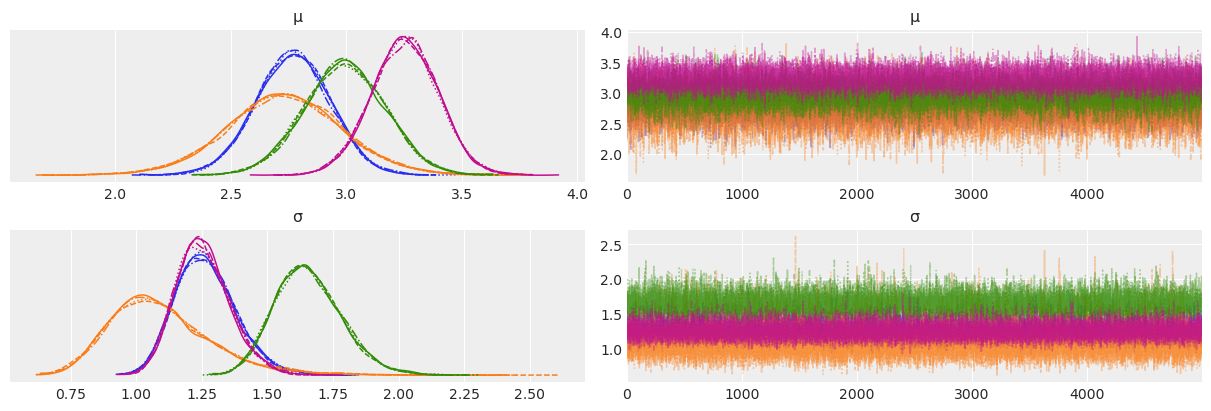

In [32]:
with pm.Model() as comparing_groups:
    μ = pm.Normal('μ', mu=0, sd=10, shape=groups)
    σ = pm.HalfNormal('σ', sd=10, shape=groups)

    y = pm.Normal('y', mu=μ[idx], sd=σ[idx], observed=tip)

    idata_cg = pm.sample(5000, return_inferencedata=True)
az.plot_trace(idata_cg)

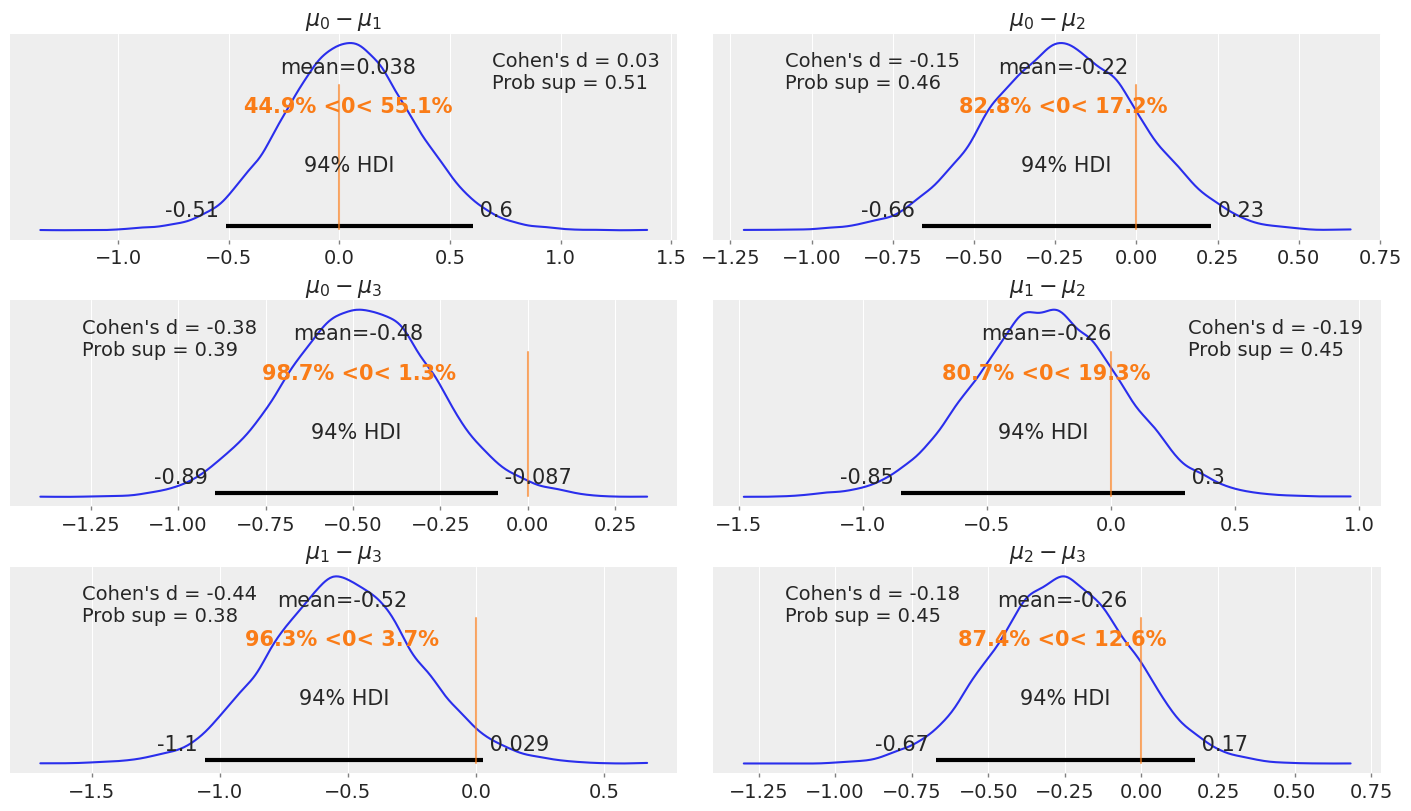

In [33]:
dist = stats.norm()

_, ax = plt.subplots(3, 2, figsize=(14, 8), constrained_layout=True)

comparisons = [(i, j) for i in range(4) for j in range(i+1, 4)]
pos = [(k, l) for k in range(3) for l in (0, 1)]

posterior_cg = idata_cg.posterior.stack(samples={"chain", "draw"})

for (i, j), (k, l) in zip(comparisons, pos):
    means_diff = posterior_cg["μ"].sel({"μ_dim_0":i}) - posterior_cg["μ"].sel({"μ_dim_0":j})
    d_cohen = (means_diff / np.sqrt((posterior_cg["σ"].sel({"σ_dim_0":i})**2 + 
                                     posterior_cg["σ"].sel({"σ_dim_0":j})**2) / 2)).mean().item()
    ps = dist.cdf(d_cohen/(2**0.5))
    az.plot_posterior(means_diff.values, ref_val=0, ax=ax[k, l])
    ax[k, l].set_title(f'$\mu_{i}-\mu_{j}$')
    ax[k, l].plot(
        0, label=f"Cohen's d = {d_cohen:.2f}\nProb sup = {ps:.2f}", alpha=0)
    ax[k, l].legend()

## Hierarchical Model

In [34]:
N_samples = [30, 30, 30]
G_samples = [18, 18, 18]

group_idx = np.repeat(np.arange(len(N_samples)), N_samples)
data = []
for i in range(0, len(N_samples)):
    data.extend(np.repeat([1, 0], [G_samples[i], N_samples[i]-G_samples[i]]))

In [35]:
with pm.Model() as model_h:
    μ = pm.Beta('μ', 1., 1.)
    κ = pm.HalfNormal('κ', 10)

    θ = pm.Beta('θ', alpha=μ*κ, beta=(1.0-μ)*κ, shape=len(N_samples))
    y = pm.Bernoulli('y', p=θ[group_idx], observed=data)

    idata_h = pm.sample(2000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ, κ, μ]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 37 seconds.


array([[<AxesSubplot:title={'center':'μ'}>,
        <AxesSubplot:title={'center':'μ'}>],
       [<AxesSubplot:title={'center':'κ'}>,
        <AxesSubplot:title={'center':'κ'}>],
       [<AxesSubplot:title={'center':'θ'}>,
        <AxesSubplot:title={'center':'θ'}>]], dtype=object)

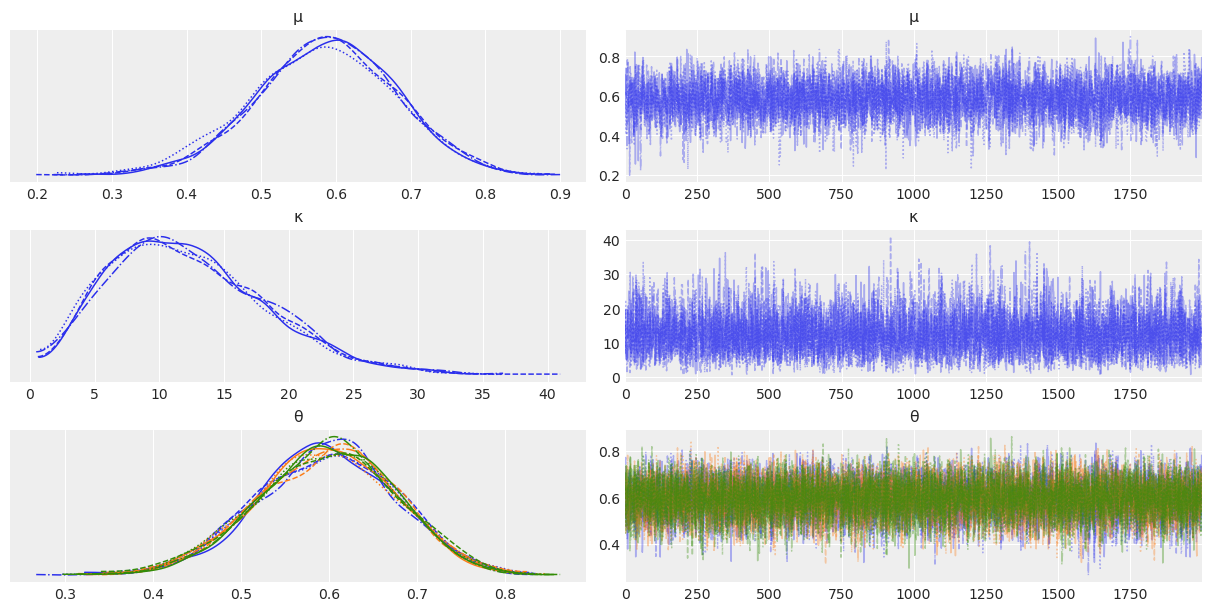

In [36]:
az.plot_trace(idata_h)

In [37]:
az.summary(idata_h)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
μ,0.586,0.094,0.415,0.766,0.001,0.001,4940.0,5047.0,1.0
κ,12.327,6.126,1.830,23.119,0.078,0.056,5787.0,4841.0,1.0
θ[0],0.596,0.079,0.449,0.745,0.001,0.001,5783.0,4760.0,1.0
θ[1],0.596,0.079,0.450,0.743,0.001,0.001,5977.0,5606.0,1.0
θ[2],0.597,0.079,0.447,0.743,0.001,0.001,6363.0,5592.0,1.0


C:\Users\User\AppData\Local\Temp\ipykernel_14472\3220850211.py:21: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout()


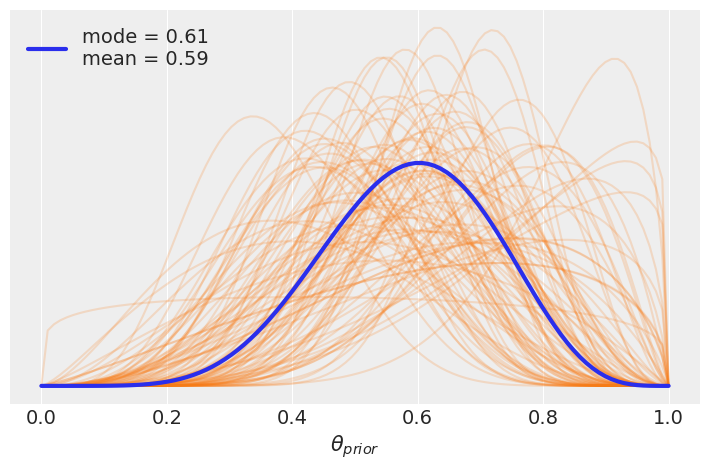

In [38]:
x = np.linspace(0, 1, 100)
posterior_h = idata_h.posterior.stack(samples={"chain", "draw"})

for i in np.random.randint(0, posterior_h.samples.size, size=100):
    u = posterior_h['μ'][i]
    k = posterior_h['κ'][i]
    pdf = stats.beta(u*k, (1.0-u)*k).pdf(x)
    plt.plot(x, pdf,  'C1', alpha=0.2)

u_mean = posterior_h['μ'].mean().item()
k_mean = posterior_h['κ'].mean().item()
dist = stats.beta(u_mean*k_mean, (1.0-u_mean)*k_mean)
pdf = dist.pdf(x)
mode = x[np.argmax(pdf)]
mean = dist.moment(1)
plt.plot(x, pdf, lw=3, label=f'mode = {mode:.2f}\nmean = {mean:.2f}')
plt.yticks([])

plt.legend()
plt.xlabel('$θ_{prior}$')
plt.tight_layout()

In [39]:
cs_data = pd.read_csv('./data/chemical_shifts_theo_exp.csv')
diff = cs_data.theo.values - cs_data.exp.values # 정답 - 실험값 구하기
idx = pd.Categorical(cs_data['aa']).codes # Categorical 하게 바꿔줌
groups = len(np.unique(idx))

In [43]:
cs_data

,ID,aa,theo,exp
0,1BM8,ILE,61.18,58.27
1,1BM8,TYR,56.95,56.18
2,1BM8,SER,56.35,56.84
3,1BM8,ALA,51.96,51.01
4,1BM8,ARG,56.54,54.64
...,...,...,...,...
1771,1KS9,LYS,55.79,57.51
1772,1KS9,ARG,58.91,59.02
1773,1KS9,LYS,59.49,58.92
1774,1KS9,GLU,59.48,58.36


In [44]:
idx

array([ 8, 17, 14, ..., 10,  5, 14], dtype=int8)

In [45]:
diff

array([ 2.91,  0.77, -0.49, ...,  0.57,  1.12, -2.48])

In [40]:
with pm.Model() as cs_nh:# non-hierarchical model
    μ = pm.Normal('μ', mu=0, sd=10, shape=groups)
    σ = pm.HalfNormal('σ', sd=10, shape=groups)

    y = pm.Normal('y', mu=μ[idx], sd=σ[idx], observed=diff)

    idata_cs_nh = pm.sample(1000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 42 seconds.


In [41]:
with pm.Model() as cs_h: # hierarchical model
    # hyper_priors
    μ_μ = pm.Normal('μ_μ', mu=0, sd=10)
    σ_μ = pm.HalfNormal('σ_μ', 10)

    # priors
    μ = pm.Normal('μ', mu=μ_μ, sd=σ_μ, shape=groups)
    σ = pm.HalfNormal('σ', sd=10, shape=groups)

    y = pm.Normal('y', mu=μ[idx], sd=σ[idx], observed=diff)

    idata_cs_h = pm.sample(1000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, μ, σ_μ, μ_μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 46 seconds.


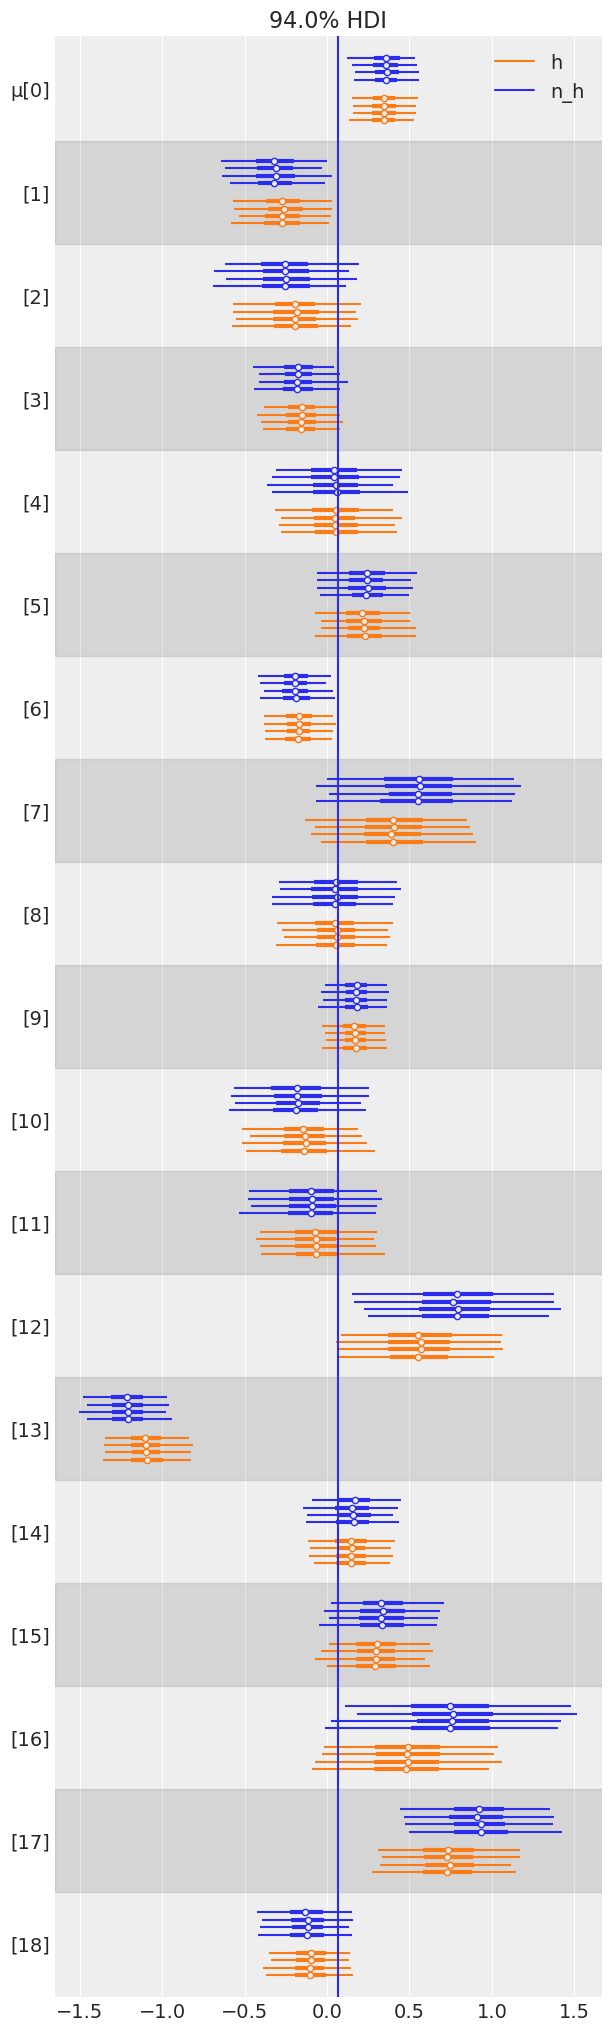

In [42]:
axes = az.plot_forest([idata_cs_nh, idata_cs_h],
                         model_names=['n_h', 'h'],
                         var_names='μ', combined=False, colors='cycle')
y_lims = axes[0].get_ylim()
axes[0].vlines(idata_cs_h.posterior['μ_μ'].mean(), *y_lims)

hierarchical model이 global mean에 조금 더 가까운 것을 알 수 있다.